# Assignment 1- Feed Forward Network using SGD and Mini Batches
By Naveena Chatti
ID C70303901

# Part B
# Please note that hidden sizes 25,50 were attempted in a loop.(While the systeme was executing the loop for 100 neurons runtime exhausted and i could not connect to the same run time).So collected the accuracy for 25 and 50 neurons from the loop  and I did the process for 150 neurons separately in this code file and taken the result for 100 neurons from the Part A code file.

In [ ]:
pip install torch torchvision matplotlib

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
# Define transformations
transform = transforms.Compose([transforms.ToTensor()])

# Load MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Create data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 14650482.72it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 444374.84it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3388817.22it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3572867.36it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
all_labels = set()

# Iterate through the training data loader
for i, (x_batch, y_batch) in enumerate(train_loader):
    all_labels.update(y_batch.numpy())
    if i >= 100:  # Limit to first 100 batches for this check
        break

print(f"Unique labels seen: {all_labels}")


Unique labels seen: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


In [ ]:
  # Define the neural network architecture
class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size=10):
        self.W1 = torch.randn(hidden_size, input_size, device=device) * np.sqrt(2. / input_size)  # He initialization
        self.W2 = torch.randn(output_size, hidden_size, device=device) * np.sqrt(2. / hidden_size)  # He initialization
        self.b1 = torch.zeros(hidden_size, 1, device=device)  # Bias for layer 1
        self.b2 = torch.zeros(output_size, 1,device=device) # Bias for layer 2

        self.device=device
    def to_device(self, device):
        self.W1 = self.W1.to(device)
        self.W2 = self.W2.to(device)
        self.b1 = self.b1.to(device)
        self.b2 = self.b2.to(device)

    def relu(self, x):
        return x.clamp(min=0)

    def tanh(self, x):
        return torch.tanh(x)

    def softmax(self, x):
        max_x = torch.max(x, dim=1, keepdim=True).values
        exp_x = torch.exp(x - max_x)  # Subtract max for numerical stability
        return exp_x / exp_x.sum(dim=1, keepdim=True)

    def forward(self, x):
    # Ensure x is reshaped to (batch_size, 784)
        x = x.view(x.size(0), -1)  # Flatten the input
        self.z1 = self.W1.mm(x.t()) + self.b1  # [hidden_size, batch_size]
        self.a1 = self.relu(self.z1)  # Apply activation
        self.z2 = self.W2.mm(self.a1) + self.b2  # [output_size, batch_size]

    # Return z2 transposed to match [batch_size, output_size]

        return self.z2  # Transpose to [batch_size, output_size]

    def backward(self, x, y, learning_rate):
        m = x.size(0)  # Batch size
        output = self.forward(x)  # Forward pass to get the output


        probabilities = self.softmax(output.t())

        # Cross-Entropy Loss for one-hot encoded targets
        loss = -(y * torch.log(probabilities.t() + 1e-12)).sum(dim=1).mean()

        # Gradients for W2 and b2 (adjusted for one-hot encoded targets)
        grad_output = probabilities - y
        grad_output /= m

        grad_W2 = grad_output.t().mm(self.a1.t())
        grad_b2 = grad_output.sum(dim=0, keepdim=True).t()

        hidden_loss = grad_output.mm(self.W2)
        grad_a1 = hidden_loss.t() * (self.z1 > 0).float()

        # Gradients for W1 and b1
        grad_W1 = grad_a1.mm(x.view(x.size(0), -1))
        grad_b1 = grad_a1.sum(dim=1, keepdim=True)

        # Update weights and biases
        self.W1 -= learning_rate * grad_W1
        self.b1 -= learning_rate * grad_b1
        self.W2 -= learning_rate * grad_W2
        self.b2 -= learning_rate * grad_b2

In [ ]:
  def train_network(network, epochs, batch_size, learning_rate):
    for epoch in range(epochs):
        for inputs, targets in tqdm(train_loader, desc="Training batches", leave=False):

            # Print the raw targets
            inputs = inputs.view(inputs.size(0), -1).to(device)  # Flatten the inputs
            targets = targets.to(device)
            # Print the targets before one-hot encoding

            # Convert targets to one-hot encoding
            targets_one_hot = torch.eye(10, device=device)[targets]

            # Forward pass
            output = network.forward(inputs)

            # Backward pass
            loss = network.backward(inputs, targets_one_hot, learning_rate)






In [ ]:
def evaluate_network(network):
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.view(inputs.size(0), -1).to(device)  # Flatten inputs for the network
            targets = targets.to(device)  # Move targets to the same device as the model

            outputs = network.forward(inputs)
            _, predicted = torch.max(outputs, 1)

            total += targets.size(0)
            correct += (predicted == targets).sum().item()  # No need to move targets again

    accuracy = correct / total if total > 0 else 0  # Prevent division by zero
    print(f"Test Accuracy: {accuracy:.4f}")  # Optional print statement
    return accuracy


In [ ]:
!pip install tqdm


In [ ]:
# Define the batch size
batch_size = 1

# Create data loaders using the batch size variable
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Parameters
hidden_sizes = [25, 50, 100, 150]
total_epochs = 150
results1 = []

# Loop over different hidden layer sizes with batch size 1
for hidden_size in hidden_sizes:
    network = NeuralNetwork(input_size=784, hidden_size=hidden_size, output_size=10)
    network.to_device(device)


    # Train the network
    for epoch in range(1, total_epochs + 1):
        with tqdm(total=len(train_loader), desc=f"Epoch {epoch}/{total_epochs} (Hidden size: {hidden_size})") as pbar:
            for inputs, targets in train_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                targets_one_hot = torch.eye(10, device=device)[targets]  # One-hot encoding

                # Forward pass
                output = network.forward(inputs)

                # Backward pass
                network.backward(inputs, targets_one_hot, learning_rate=0.01)

                pbar.update(1)

    # Evaluate the network and store the accuracy
    accuracy = evaluate_network(network)
    results1.append((hidden_size, accuracy))

# Prepare data for plotting
neurons, accuracies = zip(*results1)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(neurons, accuracies, marker='o')
plt.title('Final Network Accuracy vs Number of Neurons in Hidden Layer (Batch Size = 1)')
plt.xlabel('Number of Neurons')
plt.ylabel('Final Accuracy')
plt.xticks(neurons)
plt.grid()
plt.show()


Epoch 150/150 (Hidden size: 25): 100%|██████████| 60000/60000 [01:07<00:00, 882.68it/s]


Test Accuracy: 0.9800


Epoch 150/150 (Hidden size: 50): 100%|██████████| 60000/60000 [01:07<00:00, 883.33it/s]


Test Accuracy: 0.9800


Epoch 77/150 (Hidden size: 100):  38%|███▊      | 22696/60000 [00:25<00:42, 881.66it/s]

Note: For the 100 Neuron with 150 Epochs the accuracy is taken from part a) of the assignment which is *0.9728*

In [ ]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm

# Parameters
hidden_size = 150  # Only 150 neurons since others are already completed
total_epochs = 150
results3 = []

# Loop over the specified hidden layer size (150 neurons)
network = NeuralNetwork(input_size=784, hidden_size=hidden_size, output_size=10)
network.to_device(device)

    # Train the network
for epoch in range(1, total_epochs + 1):
        with tqdm(total=len(train_loader), desc=f"Epoch {epoch}/{total_epochs} (Hidden size: {hidden_size})") as pbar:
            for inputs, targets in train_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                targets_one_hot = torch.eye(10, device=device)[targets]  # One-hot encoding

                # Forward pass
                output = network.forward(inputs)

                # Backward pass
                network.backward(inputs, targets_one_hot, learning_rate=0.01)

                pbar.update(1)

    # Evaluate the network and store the accuracy
accuracy = evaluate_network(network)
results3.append((hidden_size, accuracy))




Epoch 150/150 (Hidden size: 150): 100%|██████████| 60000/60000 [01:24<00:00, 709.33it/s]


Test Accuracy: 0.9800


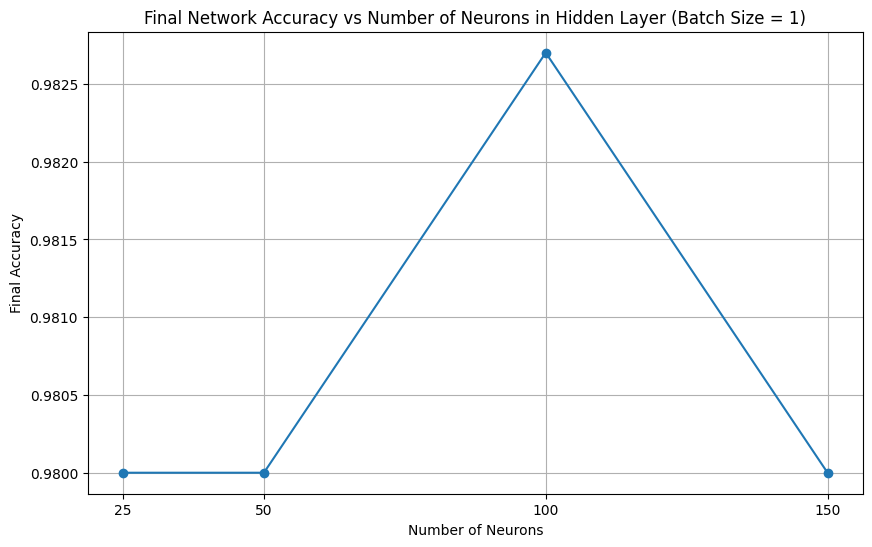

In [2]:
# Plot results
neurons_list=[25,50,100,150]
accuracies_list=[0.9800,0.9800,0.9827,0.9800]# This is is taken from the accuracies for 25,50,100,150 neurons
plt.figure(figsize=(10, 6))
plt.plot(neurons_list, accuracies_list, marker='o')
plt.title('Final Network Accuracy vs Number of Neurons in Hidden Layer (Batch Size = 1)')
plt.xlabel('Number of Neurons')
plt.ylabel('Final Accuracy')
plt.xticks(neurons_list)
plt.grid()
plt.show()
